# Установим все необходимые библиотеки и файлы

In [4]:
# установим библиотеку, чтобы можно было скачать данные напрямую с kaggle
!pip install -q kaggle

In [ ]:
# импортируем библиотеку для работы с файлами в google colab
from google.colab import files

files.upload()

In [ ]:
# используем kaggle.json для авторизации
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

In [ ]:
# скачиваем датасет с kaggle
!kaggle competitions download -c riiid-test-answer-prediction

In [ ]:
# создадим директорию и распакуем скаченный файл
!mkdir riiid-test-answer-prediction
!unzip riiid-test-answer-prediction.zip -d riiid-test-answer-prediction

In [1]:
# импортируем все необходимые для анализа библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# отключим вывод предупреждений, чтобы не засорять вывод
import warnings

warnings.filterwarnings("ignore")

# Загружаем необходимые для работы датасеты

In [7]:
# загружаем данные по датафрейму train
# ограничиваем чтение 10^7 из-за ограничения по памяти
train = pd.read_csv('/content/riiid-test-answer-prediction/train.csv', nrows=10**7)

In [8]:
# посмотрим на данные
display(train.head(),train.tail())

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
9999995,9999995,646228695,216747867,8805,0,410,1,1,23000.0,True
9999996,9999996,646321314,216747867,5708,0,411,0,0,13000.0,True
9999997,9999997,646393443,216747867,5434,0,412,0,0,66000.0,True
9999998,9999998,646445632,216747867,6429,0,413,3,1,37000.0,True
9999999,9999999,690225760,216747867,9010,0,414,2,1,16000.0,True


Данные по датасету

* row_id: (int64) Код идентификатора строки.

* timestamp: (int64) Время в миллисекундах между взаимодействием пользователя и завершением первого события от этого пользователя.

* user_id: (int32) Код идентификатора пользователя.

* content_id: (int16) Код идентификатора взаимодействия пользователя.

* content_type_id: (int8) 0, если событие было вопросом, адресованным пользователю, 1, если событием было то, что пользователь смотрел лекцию.

* task_container_id: (int16) Код идентификатора блока вопросов или лекций. Например, пользователь может увидеть три вопроса подряд перед тем, как увидеть объяснения к любому из них. Эти три будут иметь общий task_container_id.

* user_answer: (int8) Ответ пользователя на вопрос, если таковой имеется. Считать -1 как пустое значение, для лекций.

* answered_correctly: (int8) Если пользователь ответил правильно. Считать -1 как пустое значение, для лекций.

* prior_question_elapsed_time: (float32) Среднее время в миллисекундах, которое потребовалось пользователю для ответа на каждый вопрос в предыдущем наборе вопросов, игнорируя любые лекции между ними. Значение равно нулю для первой группы вопросов или лекции пользователя. Обратите внимание, что время является средним временем, которое потребовалось пользователю для решения каждого вопроса в предыдущем наборе.

* prior_question_had_explanation: (bool) Был ли у пользователя просмотр объяснений и правильных ответов после ответа на предыдущий набор вопросов, игнорируя любые лекции между ними. Значение применяется ко всему набору вопросов и равно нулю для первой группы вопросов или лекции пользователя. Обычно первые несколько вопросов, которые видит пользователь, являются частью диагностического теста для ознакомления, где он не получает никакой обратной связи.

In [9]:
# размер датасета
train.shape

(10000000, 10)

In [10]:
# Уменьшим датасет
X = train.drop(columns=["answered_correctly"], axis=1)
y = train["answered_correctly"]

In [11]:
# Разбиваем трейнтестом для сохранения пропорций таргета и приближения
# к базовому датасету
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.3, stratify=y)

In [12]:
# Рекомбинируем датасет который содержит 30% выборки
train_data = pd.concat([X_train, y_train], axis=1)

In [13]:
# Смотрим на итоговый размер
train_data.shape

(3000000, 10)

In [14]:
# скопируем для дальнейших манипуляция
train = train_data.copy()

In [15]:
# изучим на предмет дупликатов
train[train.duplicated()]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly


In [16]:
# Удалим индексы
train_processed = train.drop(["row_id"], axis=1)

In [17]:
# Загрузим лекции
lectures = pd.read_csv('/content/riiid-test-answer-prediction/lectures.csv')

Данные по датасету с лекциями

* lecture_id: внешний ключ для столбца train/test content_id, когда тип контента – лекция (1).

* part: код верхнего уровня категории для лекции.

* tag: один код тега для лекции. Значение тегов предоставляться не будет, но эти коды достаточны для группировки лекций вместе.

* type_of: краткое описание основной цели лекции.

In [18]:
# Посмотрим на данные лекций
display(lectures.head(),lectures.tail())

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


,lecture_id,tag,part,type_of
413,32535,8,5,solving question
414,32570,113,3,solving question
415,32604,24,6,concept
416,32625,142,2,concept
417,32736,82,3,concept


Данные по датасету с вопросами
* question_id: внешний ключ для столбца train/test content_id, когда тип контента – вопрос (0).

* bundle_id: код для вопросов, которые подаются вместе.

* correct_answer: ответ на вопрос. Его можно сравнить с колонной train user_answer, чтобы проверить, был ли прав пользователь.

* part: соответствующий раздел теста TOEIC.

* tags: один или несколько подробных кодов тегов для вопроса. Значение тегов предоставляться не будет, но эти коды достаточны для группировки вопросов вместе.

In [19]:
# изучим на предмет дубликатов
lectures[lectures.duplicated()]

,lecture_id,tag,part,type_of


In [20]:
# размер лекций
lectures.shape

(418, 4)

In [22]:
# загрузим вопросы
questions = pd.read_csv('/content/riiid-test-answer-prediction/questions.csv')

In [23]:
# смотрим на данные вопросов
display(questions.head(),questions.tail())

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


,question_id,bundle_id,correct_answer,part,tags
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125
13522,13522,13522,3,5,55


In [24]:
# Дубли в вопросах
questions[questions.duplicated()]

,question_id,bundle_id,correct_answer,part,tags


In [25]:
# размер вопросов
questions.shape

(13523, 5)

# Избавляемся от нормализованности и объединим все в один датафрейм

In [26]:
# для начала посмотрим на структуру основной таблицы
train_processed.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly
2949094,1863074943,64101738,668,0,365,3,20000.0,True,1
1575730,544100368,33582234,6805,0,143,2,30250.0,True,1
5194246,34064541814,111466429,818,0,771,1,15000.0,True,1
8292936,2959881660,180395464,11773,0,1395,1,14000.0,True,0
1299104,228998,27540657,2947,0,6,3,19000.0,False,0


In [27]:
# объединим train с lectures
data_lectures = pd.merge(
    left=train_processed, right=lectures,
    left_on="content_id", right_on="lecture_id",
)

# удалим ключ
data_lectures = data_lectures.drop(["lecture_id"], axis=1)

# Посмотрим на результат
display(data_lectures.head())

print(data_lectures.shape)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly,tag,part,type_of
0,228406696,50349999,9896,1,142,-1,NaN,False,-1,167,5,concept
1,1931472517,74794098,641,0,35,3,17000.0,True,1,134,6,solving question
2,13628215886,80411998,6808,0,2792,2,60250.0,True,0,129,2,intention
3,1208095461,90095339,25843,1,411,-1,NaN,False,-1,164,1,concept
4,1728944634,214749411,3255,1,1044,-1,NaN,False,-1,60,5,concept


(97231, 12)


In [28]:
# объединим data с questiones
data_question = pd.merge(
    left=train_processed, right=questions,
    left_on="content_id", right_on="question_id",
)

# удаляем ключ
data_question = data_question.drop(["question_id"], axis=1)

# смотрим результат
display(data_question.head())
print(data_question.shape)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly,bundle_id,correct_answer,part,tags
0,1863074943,64101738,668,0,365,3,20000.0,True,1,668,3,2,143 141 81 92
1,544100368,33582234,6805,0,143,2,30250.0,True,1,6805,2,6,173
2,34064541814,111466429,818,0,771,1,15000.0,True,1,818,1,2,148 32 162 92 102
3,2959881660,180395464,11773,0,1395,1,14000.0,True,0,11773,3,2,143 176 81 92
4,228998,27540657,2947,0,6,3,19000.0,False,0,2946,1,4,74 67 92


(2964281, 13)


In [29]:
# Создадим общий денормализованный датасет
processed_data = pd.concat([data_question, data_lectures])
display(processed_data)
print(processed_data.shape)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly,bundle_id,correct_answer,part,tags,tag,type_of
0,1863074943,64101738,668,0,365,3,20000.0,True,1,668.0,3.0,2,143 141 81 92,NaN,NaN
1,544100368,33582234,6805,0,143,2,30250.0,True,1,6805.0,2.0,6,173,NaN,NaN
2,34064541814,111466429,818,0,771,1,15000.0,True,1,818.0,1.0,2,148 32 162 92 102,NaN,NaN
3,2959881660,180395464,11773,0,1395,1,14000.0,True,0,11773.0,3.0,2,143 176 81 92,NaN,NaN
4,228998,27540657,2947,0,6,3,19000.0,False,0,2946.0,1.0,4,74 67 92,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97226,190394501,180289139,23165,1,315,-1,NaN,False,-1,NaN,NaN,5,NaN,127.0,concept
97227,1385512116,135676064,3852,0,225,1,38000.0,True,1,NaN,NaN,4,NaN,161.0,solving question
97228,14977019865,2475583,1003,0,2570,0,20000.0,True,1,NaN,NaN,7,NaN,98.0,concept
97229,6174187618,214015273,32168,1,228,-1,NaN,False,-1,NaN,NaN,4,NaN,136.0,concept


(3061512, 15)


In [31]:
# Сохраним в CSV для сохранения предыдущих шагов
with open("/content/riiid-test-answer-prediction/data/processed_data.csv", "w", encoding="utf-8") as file:
    processed_data.to_csv(file, index=False)

In [32]:
# по новой инициализируем датафрейм
processed_data = pd.read_csv("/content/riiid-test-answer-prediction/data/processed_data.csv")

In [33]:
# Посмотрим на данные
display(processed_data.head(), processed_data.tail())
print(processed_data.shape)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly,bundle_id,correct_answer,part,tags,tag,type_of
0,1863074943,64101738,668,0,365,3,20000.0,True,1,668.0,3.0,2,143 141 81 92,NaN,NaN
1,544100368,33582234,6805,0,143,2,30250.0,True,1,6805.0,2.0,6,173,NaN,NaN
2,34064541814,111466429,818,0,771,1,15000.0,True,1,818.0,1.0,2,148 32 162 92 102,NaN,NaN
3,2959881660,180395464,11773,0,1395,1,14000.0,True,0,11773.0,3.0,2,143 176 81 92,NaN,NaN
4,228998,27540657,2947,0,6,3,19000.0,False,0,2946.0,1.0,4,74 67 92,NaN,NaN


,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly,bundle_id,correct_answer,part,tags,tag,type_of
3061507,190394501,180289139,23165,1,315,-1,NaN,False,-1,NaN,NaN,5,NaN,127.0,concept
3061508,1385512116,135676064,3852,0,225,1,38000.0,True,1,NaN,NaN,4,NaN,161.0,solving question
3061509,14977019865,2475583,1003,0,2570,0,20000.0,True,1,NaN,NaN,7,NaN,98.0,concept
3061510,6174187618,214015273,32168,1,228,-1,NaN,False,-1,NaN,NaN,4,NaN,136.0,concept
3061511,3448280223,193371222,4187,0,453,0,27000.0,True,1,NaN,NaN,1,NaN,70.0,solving question


(3061512, 15)


In [34]:
# Переведем timestamp в минуты
processed_data["timestamp"] = processed_data["timestamp"] / 1000 / 60

processed_data["prior_question_elapsed_time"] = (
    processed_data["prior_question_elapsed_time"] / 1000 / 60
)

In [35]:
# заполним пропуски после
# заполняем лэйблами, где пропускам будет присваиваться категория
tags = LabelEncoder()
processed_data["tags"] = tags.fit_transform(processed_data["tags"])

tag = LabelEncoder()
processed_data["tag"] = tag.fit_transform(processed_data["tag"])

type_of = LabelEncoder()
processed_data["type_of"] = type_of.fit_transform(processed_data["type_of"])

bundle_id = LabelEncoder()
processed_data["bundle_id"] = bundle_id.fit_transform(processed_data["bundle_id"])

# заполним пропуски
processed_data["prior_question_elapsed_time"].fillna(0, inplace=True)
processed_data["prior_question_had_explanation"].fillna(False, inplace=True)

processed_data["correct_answer"].fillna(-1, inplace=True)


display(processed_data.head(), processed_data.tail())

# проверим на пропущенные значения
print(processed_data.isnull().sum())

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly,bundle_id,correct_answer,part,tags,tag,type_of
0,31051.249050,64101738,668,0,365,3,0.333333,True,1,667,3.0,2,541,151,4
1,9068.339467,33582234,6805,0,143,2,0.504167,True,1,5140,2.0,6,850,151,4
2,567742.363567,111466429,818,0,771,1,0.250000,True,1,817,1.0,2,660,151,4
3,49331.361000,180395464,11773,0,1395,1,0.233333,True,0,8459,3.0,2,555,151,4
4,3.816633,27540657,2947,0,6,3,0.316667,False,0,1913,1.0,4,1179,151,4


,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly,bundle_id,correct_answer,part,tags,tag,type_of
3061507,3173.241683,180289139,23165,1,315,-1,0.000000,False,-1,9729,-1.0,5,1517,99,0
3061508,23091.868600,135676064,3852,0,225,1,0.633333,True,1,9729,-1.0,4,1517,128,2
3061509,249616.997750,2475583,1003,0,2570,0,0.333333,True,1,9729,-1.0,7,1517,77,0
3061510,102903.126967,214015273,32168,1,228,-1,0.000000,False,-1,9729,-1.0,4,1517,106,0
3061511,57471.337050,193371222,4187,0,453,0,0.450000,True,1,9729,-1.0,1,1517,56,2


timestamp                         0
user_id                           0
content_id                        0
content_type_id                   0
task_container_id                 0
user_answer                       0
prior_question_elapsed_time       0
prior_question_had_explanation    0
answered_correctly                0
bundle_id                         0
correct_answer                    0
part                              0
tags                              0
tag                               0
type_of                           0
dtype: int64


In [36]:
# Смотрим типы данных и перекодируем категориальные признаки
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3061512 entries, 0 to 3061511
Data columns (total 15 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       float64
 1   user_id                         int64  
 2   content_id                      int64  
 3   content_type_id                 int64  
 4   task_container_id               int64  
 5   user_answer                     int64  
 6   prior_question_elapsed_time     float64
 7   prior_question_had_explanation  bool   
 8   answered_correctly              int64  
 9   bundle_id                       int64  
 10  correct_answer                  float64
 11  part                            int64  
 12  tags                            int64  
 13  tag                             int64  
 14  type_of                         int64  
dtypes: bool(1), float64(3), int64(11)
memory usage: 329.9 MB


* tags - закодированные теги вопросов в строковом формате. Разделитель - пробел (есть смысл использовать one hot encoding).
* type_of - краткое описание основной цели лекции (есть смысл проверить количество категорий и использовать label encoder)

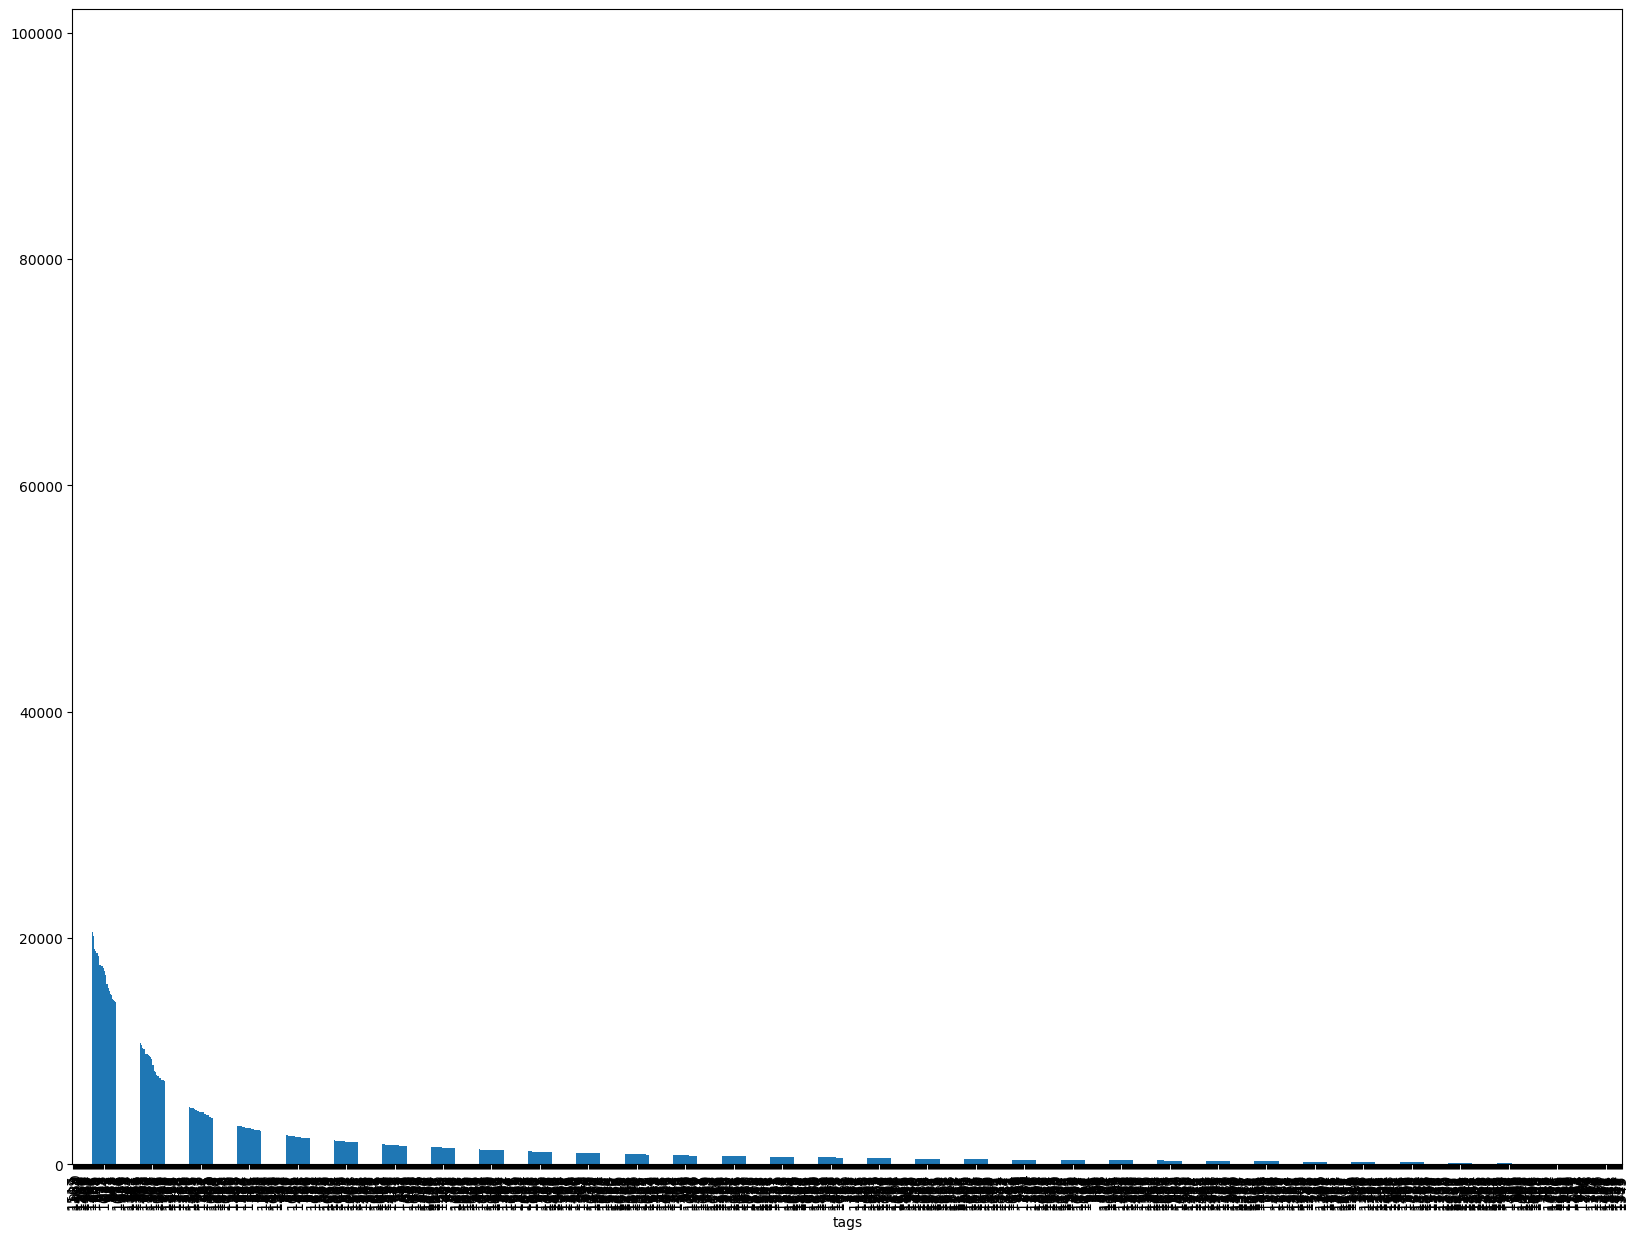

Количество уникальных тегов 1518


In [37]:
# Посмотрим на распределение tags
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
processed_data["tags"].value_counts().plot(kind="bar")
plt.show()
print(f"Количество уникальных тегов {processed_data['tags'].nunique()}")

Видно разбиение тегов по батчам (в районе 30 групп)

In [39]:
# Создадим новую колонку с перекодированными значениями
# и разобьем по бинам
processed_data["tags_group"] = pd.cut(
    processed_data["tags"], bins=range(0, 1521, 50), labels=range(30)
)

In [40]:
# Удалим тэги и посмотрим на данные
processed_data = processed_data.drop(["tags"], axis=1)


In [41]:
processed_data.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly,bundle_id,correct_answer,part,tag,type_of,tags_group
0,31051.249050,64101738,668,0,365,3,0.333333,True,1,667,3.0,2,151,4,10
1,9068.339467,33582234,6805,0,143,2,0.504167,True,1,5140,2.0,6,151,4,16
2,567742.363567,111466429,818,0,771,1,0.250000,True,1,817,1.0,2,151,4,13
3,49331.361000,180395464,11773,0,1395,1,0.233333,True,0,8459,3.0,2,151,4,11
4,3.816633,27540657,2947,0,6,3,0.316667,False,0,1913,1.0,4,151,4,23


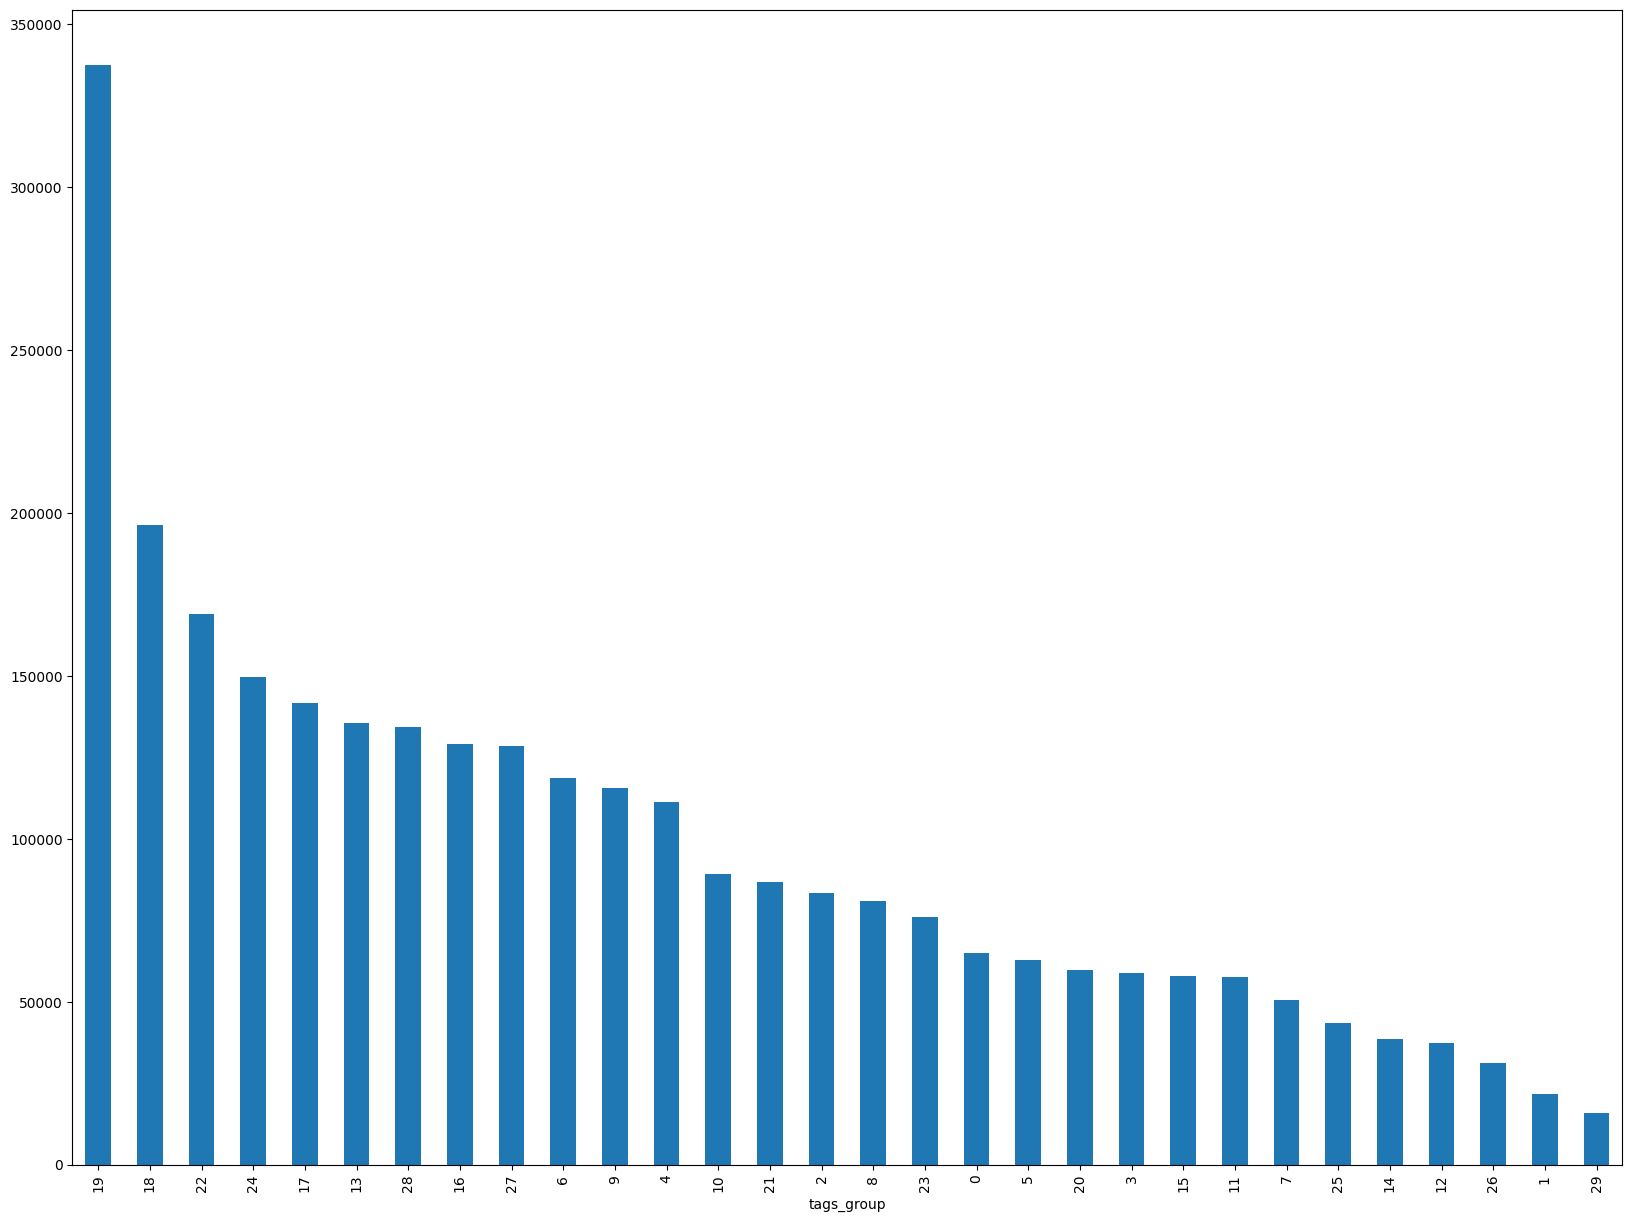

Количество уникальных тегов 30


In [42]:
# Теперь рассмотрим распределение частотности тегов
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
processed_data["tags_group"].value_counts().plot(kind="bar")
plt.show()
print(f"Количество уникальных тегов {processed_data['tags_group'].nunique()}")

Отметим популярность ряда групп тегов в выборке.

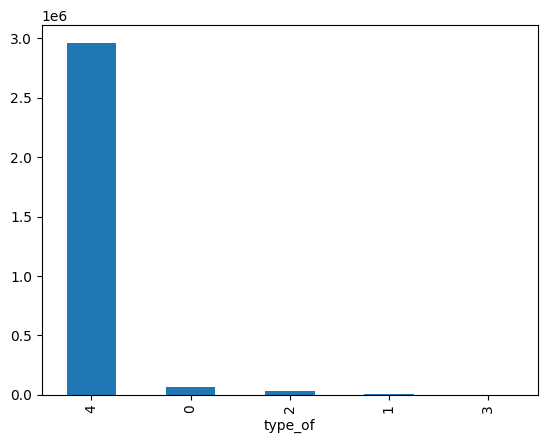

In [44]:
# Посмотрим на типы лекций
processed_data["type_of"].value_counts().plot(kind="bar")
plt.show()

In [45]:
# Смотрим количество уникальных пользователей
print(f"Количество уникальных пользователей: \
{processed_data['user_id'].nunique()}")

Количество уникальных пользователей: 39429


Количество типов взаимодействия: 2


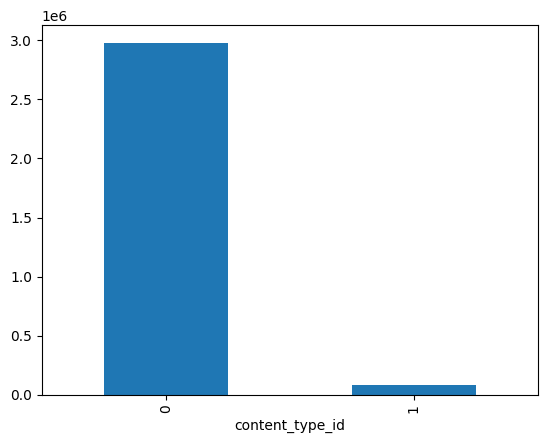

In [46]:
# Смотрим количество уникальных типов взаимодействия
processed_data["content_type_id"].value_counts().plot(kind="bar")
print(f"Количество типов взаимодействия: \
{processed_data['content_type_id'].nunique()}")

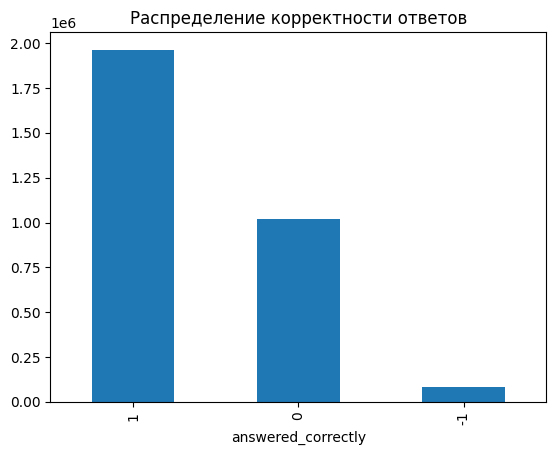

In [47]:
# Смотрим распределение значений целевой переменной
processed_data["answered_correctly"].value_counts().plot(kind="bar")
plt.title("Распределение корректности ответов")
plt.show()

Таргетом для последующего моделирования бинарной классификации являются метки 1 и 0. Возможно нет смысла предсказывать отсутствие ответа на лекционном материале.

In [48]:
# количество строк соответствующих лекциям
processed_data[processed_data["answered_correctly"] == -1].shape

(81519, 15)

Видно, что можно облегчить датасет.

In [50]:
# Фильтруем и смотрим форму
data = processed_data[processed_data["answered_correctly"] != -1]
data.shape

(2979993, 15)

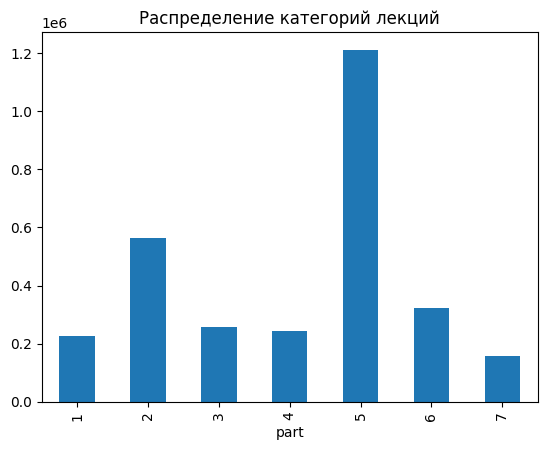

In [51]:
# Посмотрим распределение значений категориальных переменных
data["part"].value_counts().sort_index().plot(kind="bar")
plt.title("Распределение категорий лекций")
plt.show()

In [52]:
# функция расчета процента правильных ответов относительно фита
def calculate_percent_correct(field, data = processed_data):
    correct_data = (
        data[data.answered_correctly != -1]
        .groupby([field, "answered_correctly"])
        .size()
        .unstack()
    )
    correct_data["Percent_correct"] = round(
        correct_data[1] / (correct_data[0] + correct_data[1]), 2
    )
    correct_data.sort_values(by="Percent_correct", ascending=False, inplace=True)
    return correct_data["Percent_correct"]

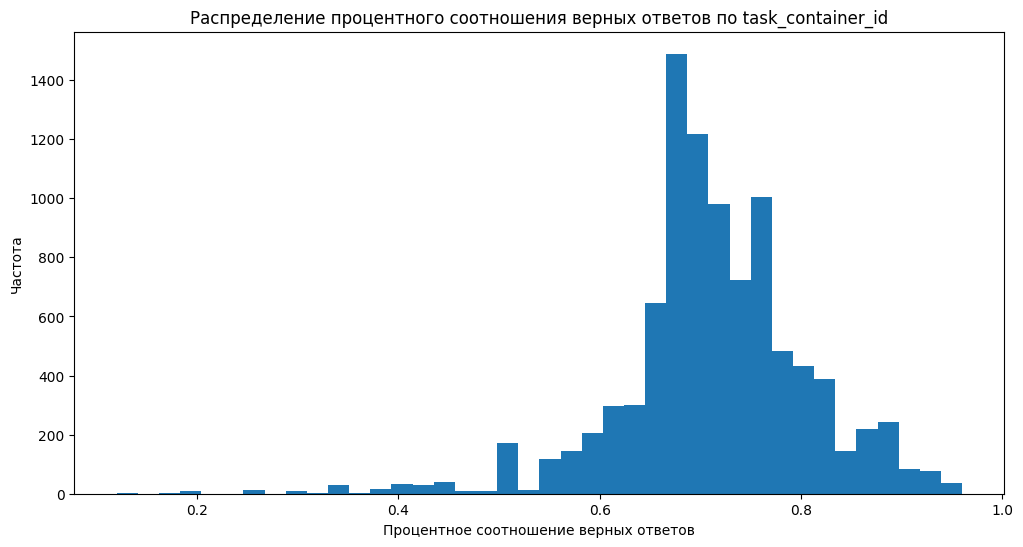

In [53]:
# распределение процентного соотношения корректных ответов в контексте одного фита
task_id_correct = calculate_percent_correct("task_container_id")

fig, ax = plt.subplots(figsize=(12, 6))
task_id_correct.plot.hist(bins=40, ax=ax)
ax.set_title(
    "Распределение процентного соотношения верных ответов по task_container_id"
)
ax.set_xlabel("Процентное соотношение верных ответов")
ax.set_ylabel("Частота")
plt.show()

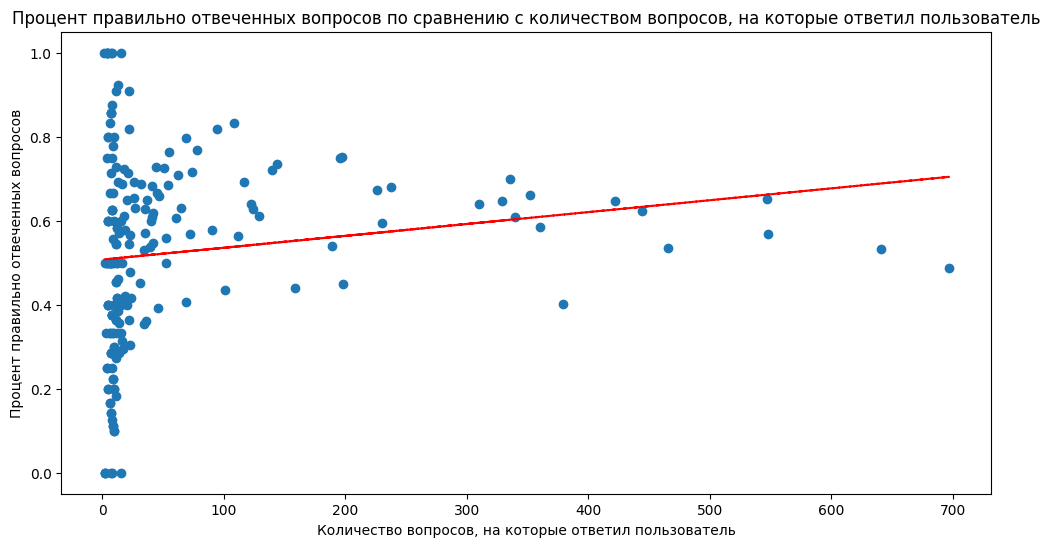

In [54]:
# построим диаграмму рассеивания для тренда
user_percent = processed_data.groupby("user_id")["answered_correctly"].agg(
    Mean="mean", Answers="count"
)

user_percent = user_percent.query("Answers <= 1000").sample(n=200, random_state=1)

fig = plt.figure(figsize=(12, 6))
x = user_percent.Answers
y = user_percent.Mean
plt.scatter(x, y, marker="o")
plt.title(
    "Процент правильно отвеченных вопросов по сравнению с количеством вопросов, на которые ответил пользователь"
)
plt.xticks(rotation=0)
plt.xlabel("Количество вопросов, на которые ответил пользователь")
plt.ylabel("Процент правильно отвеченных вопросов")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")

plt.show()

Видна положительная связь между колличеством правильных ответов и общим колличеством ответов данных пользователем

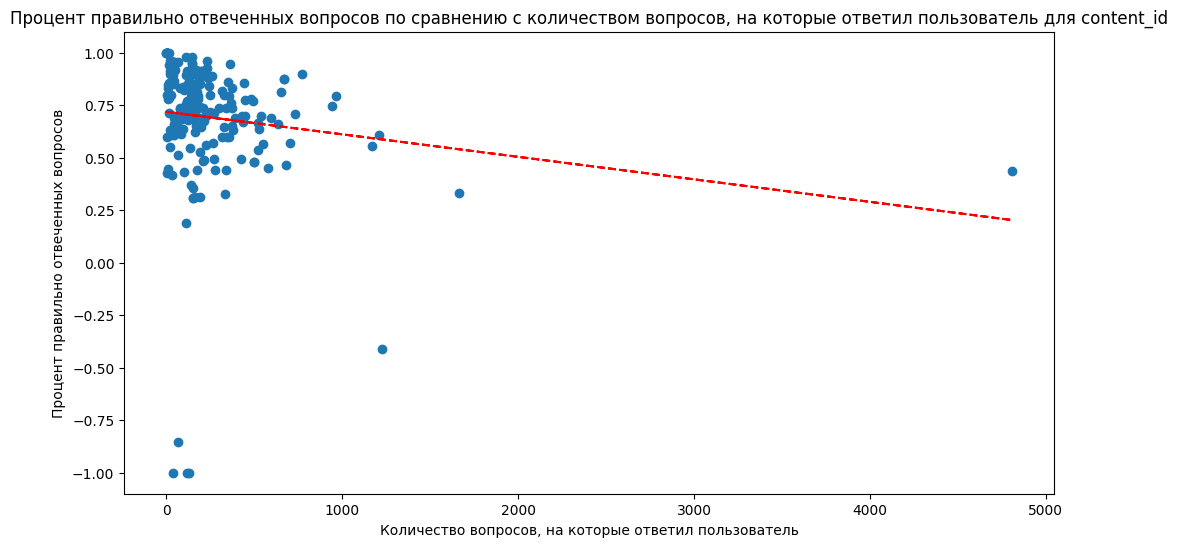

In [55]:
# То же самое для другого фита
content_percent = processed_data.groupby("content_id")["answered_correctly"].agg(
    Mean="mean", Answers="count"
)

content_percent = content_percent.query("Answers <= 25000").sample(
    n=200, random_state=1, replace=True
)

fig = plt.figure(figsize=(12, 6))
x = content_percent.Answers
y = content_percent.Mean
plt.scatter(x, y, marker="o")
plt.title(
    "Процент правильно отвеченных вопросов по сравнению с количеством вопросов, на которые ответил пользователь для content_id"
)
plt.xticks(rotation=0)
plt.xlabel("Количество вопросов, на которые ответил пользователь")
plt.ylabel("Процент правильно отвеченных вопросов")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")

plt.show()

Видна обратная связь с content_id, сложность может быть распределена неравномерно.

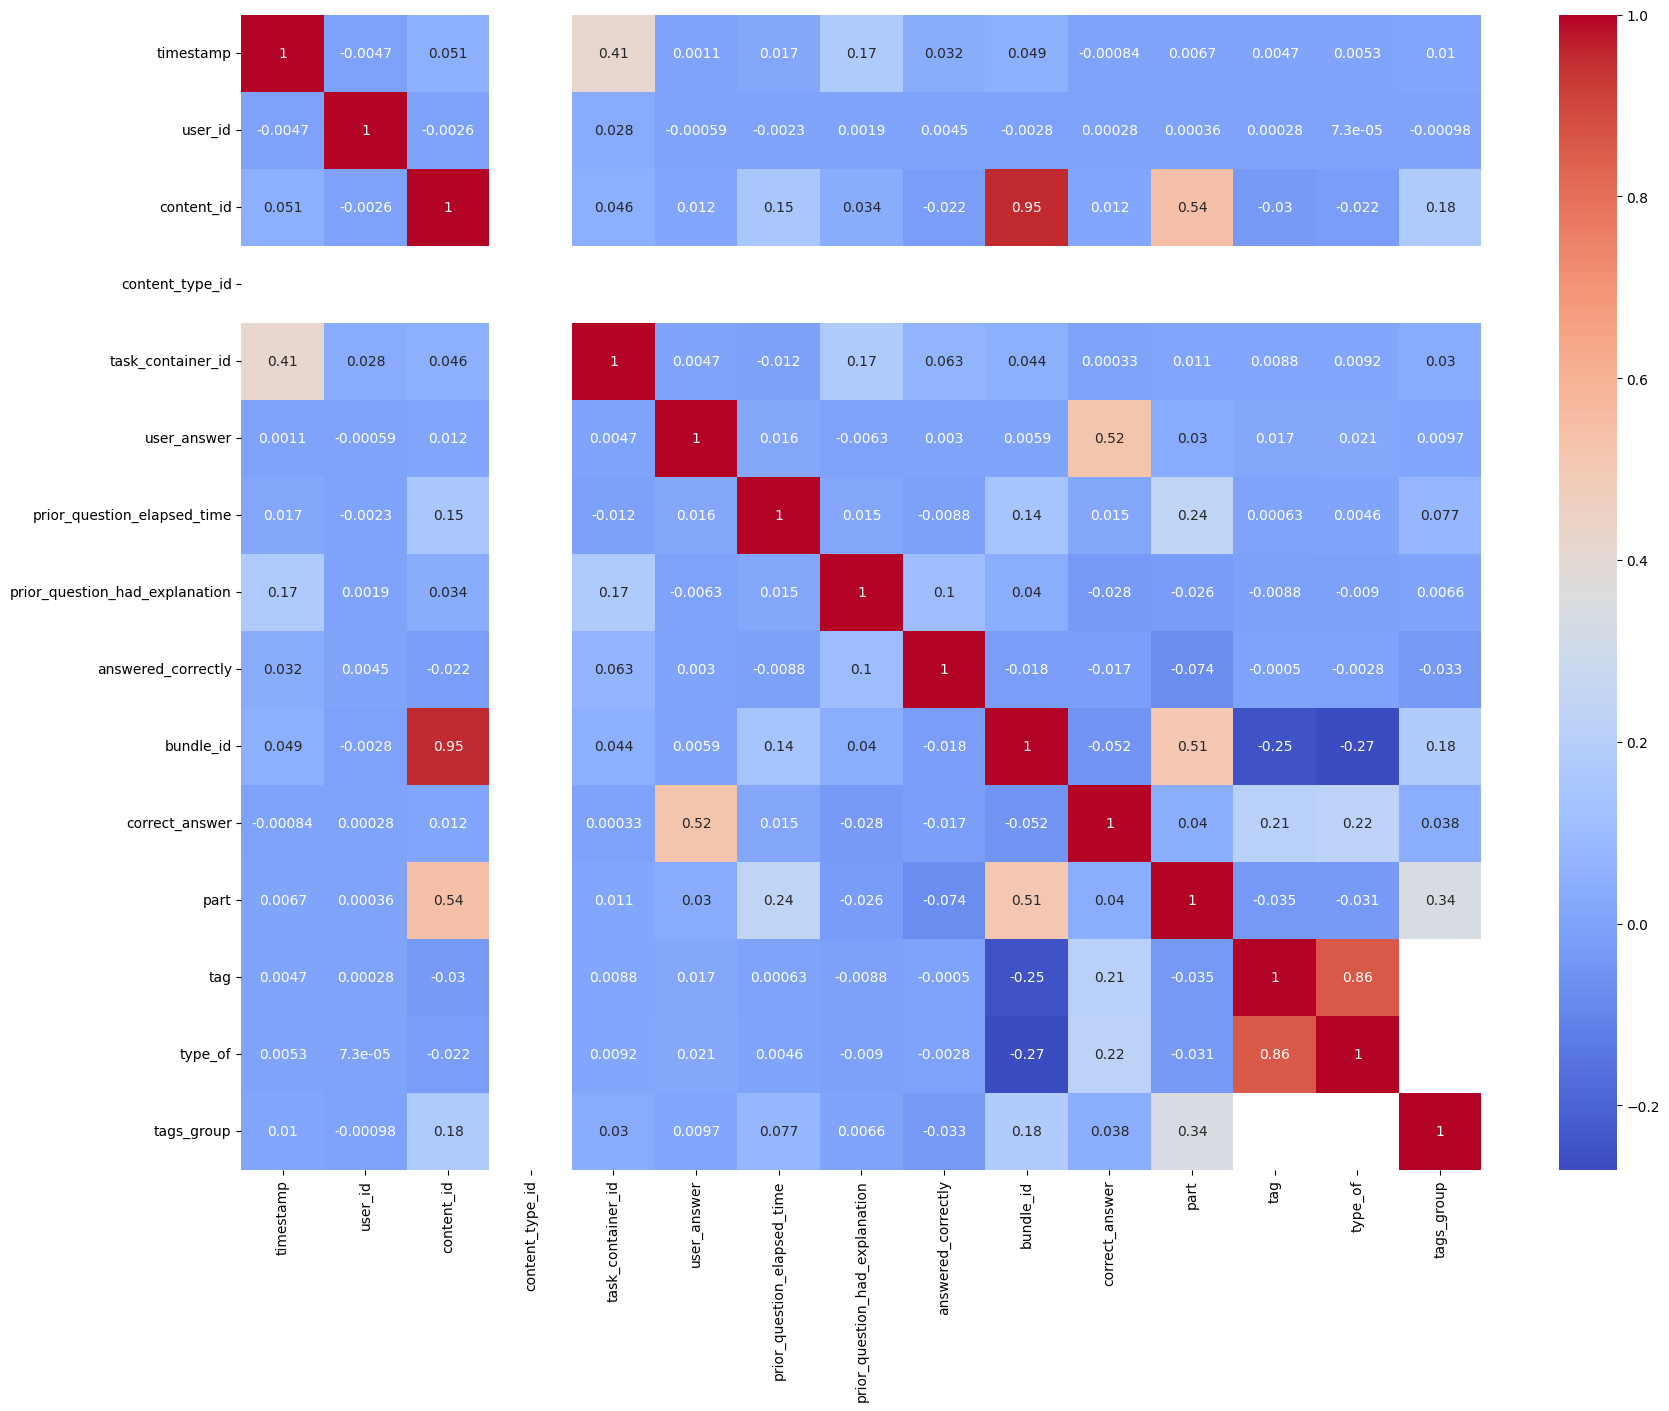

In [56]:
# Найдем корреляции между переменными и удалением мультиколлинеарности
correlation_matrix = data.corr()
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes)
plt.show()

По мультиколлинеарность.

1. Есть сильная корреляция между bundle_id и content_id, влияние на таргет (answered corretly) меньше у bundle_id, убираем.

2. Есть сильная корреляция между type_of и tag/content_type_id, влияние на таргет (answered corretly) меньше у tag, за счет того что есть вероятность мультиколлинеарности с content_type_id, убираем type_of.

---

user_id имеет низкое влияние, его так же убираем.

In [57]:
# Убираем указанные колонки
data.drop(
    columns=[
        "bundle_id",
        "user_id",
        "type_of"
    ], inplace=True
)

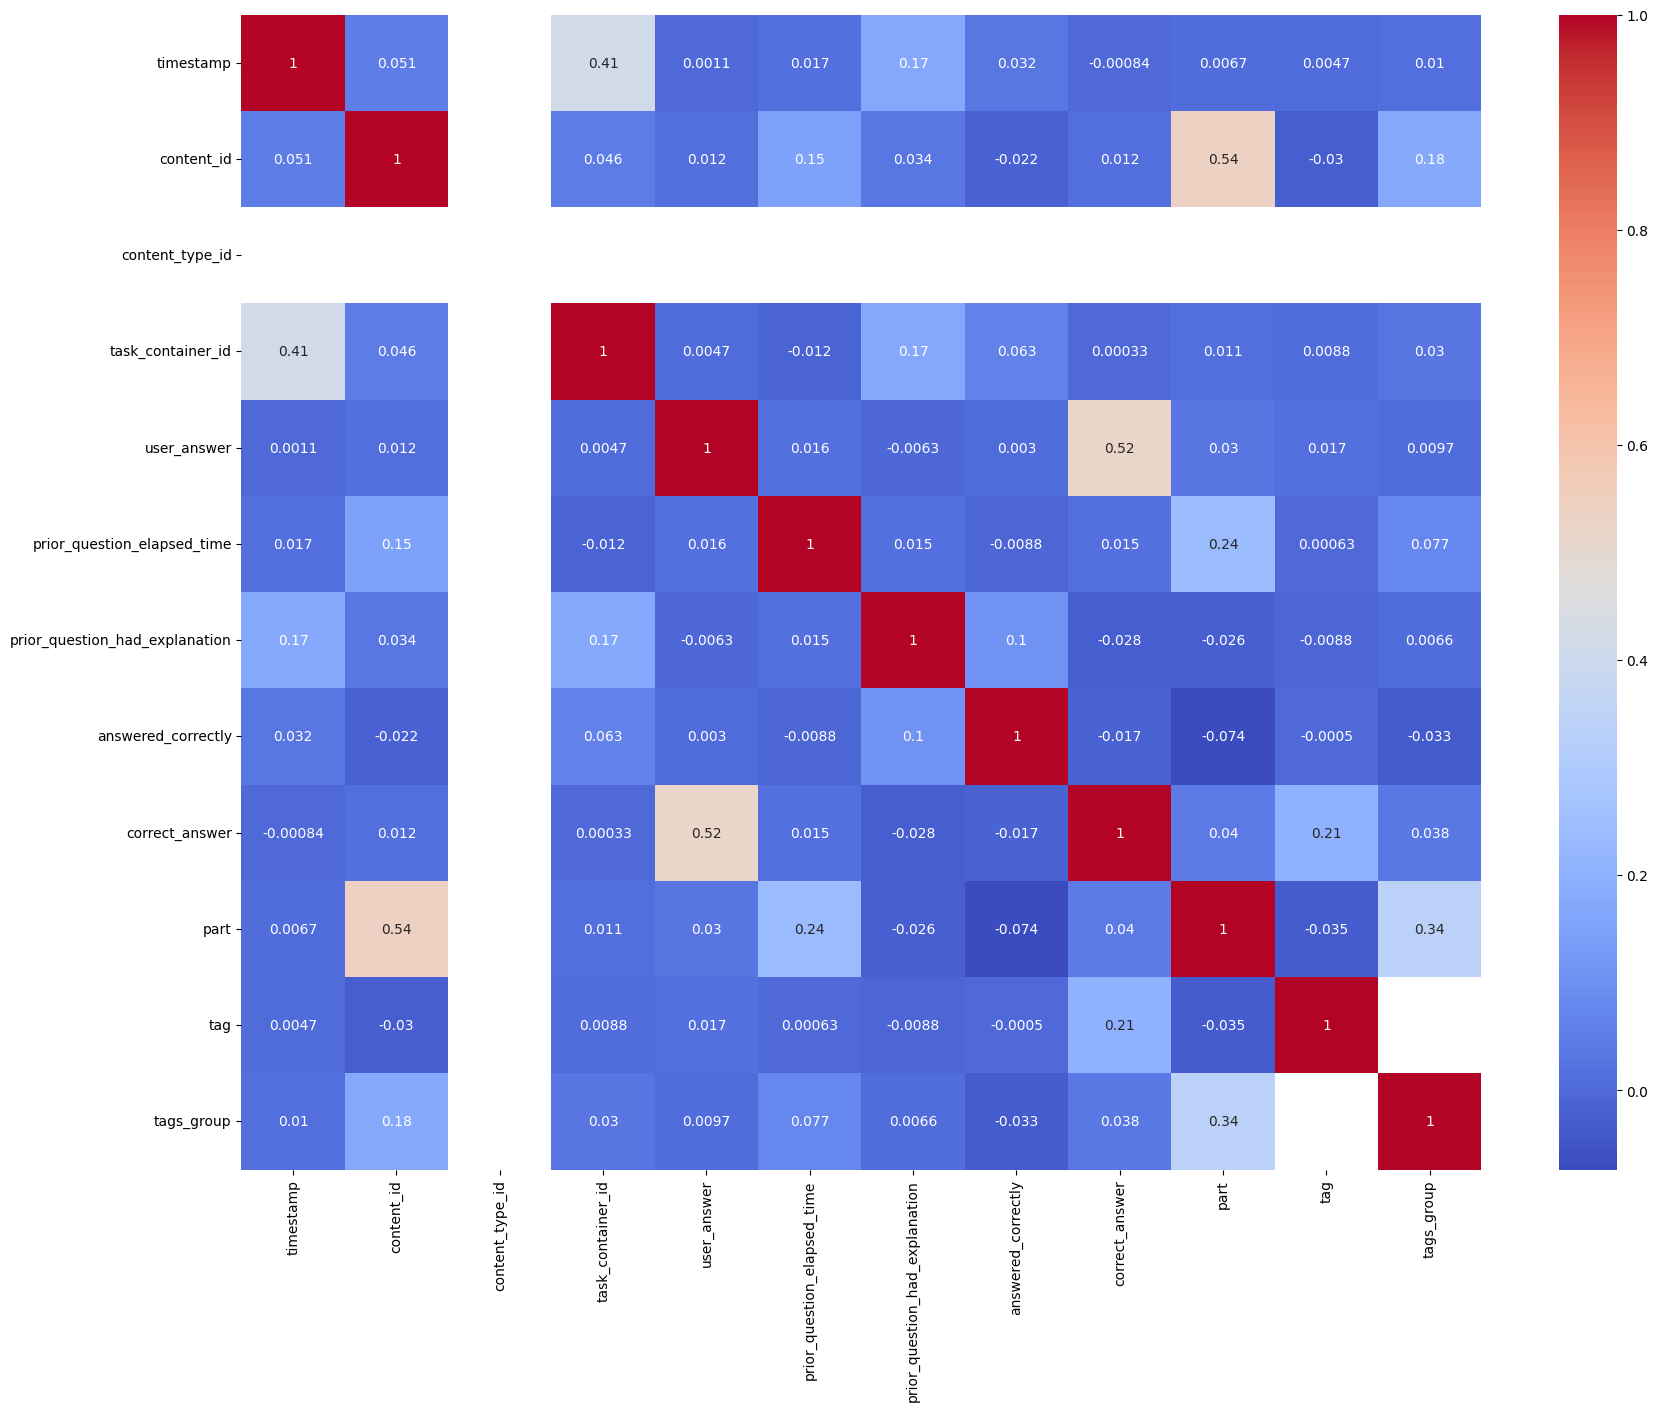

In [58]:
# Посмотрим на матрицу
# отметим наличие констант
correlation_matrix = data.corr()
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes)
plt.show()

# Углубимся в оставшиеся фичи

# content_type_id

Количество типов взаимодействия: 1


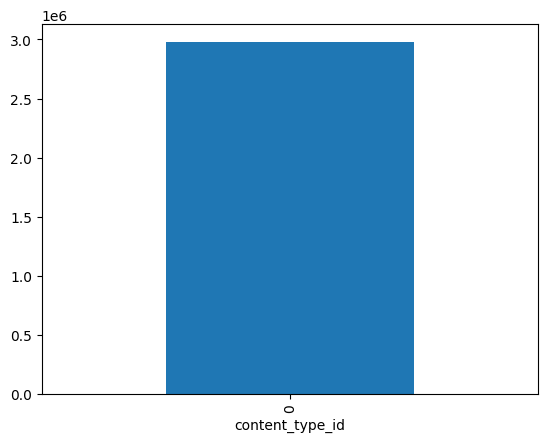

In [59]:
# смотрим количество уникальных типов взаимодействия
data["content_type_id"].value_counts().plot(kind="bar")
print(f"Количество типов взаимодействия: \
{data['content_type_id'].nunique()}")

Остались только тесты, поэтому удаляем константы.

In [60]:
# удаляем константы
data = data.drop(columns=["content_type_id"], axis=1)

# content_id

Количество типов взаимодействия: 13444


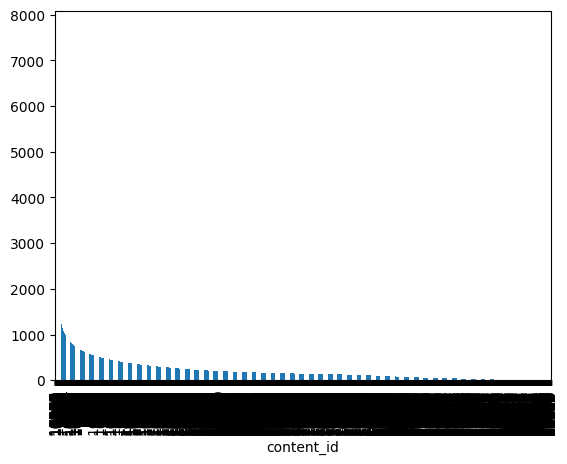

In [61]:
# смотрим количество уникальных типов взаимодействия
data["content_id"].value_counts().plot(kind="bar")
print(f"Количество типов взаимодействия: \
{data['content_id'].nunique()}")

Квантированная информация. Количество уникальных значений разумно, в условиях объема датасета. Имеет не существенное влияние на таргет, из-за возможности ухудшении производительности кандидат либо на удаление, либо же кодирование. Id-шники сложно разбить по пороговому значению без нарушения логики, поэтому вариант с удаление в приоритете.

# timestamp

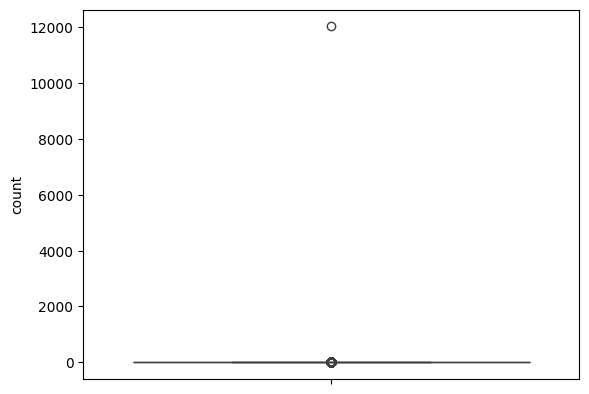

In [62]:
# boxplot временного взаимодействия, ищем выбросы
sns.boxplot(data["timestamp"].value_counts())
plt.show()

Выявили потенциальные выбросы или аномалии, которые могут повлиять на конечную метрику модели, приведем признак к логарифмическому масштабу.

In [63]:
data["timestamp"] = np.log(data["timestamp"]+1)
display(data["timestamp"].describe())

,timestamp
count,2.979993e+06
mean,9.894934e+00
std,3.089685e+00
min,0.000000e+00
25%,9.034640e+00
50%,1.067616e+01
75%,1.199829e+01
max,1.416038e+01


# task_container_id

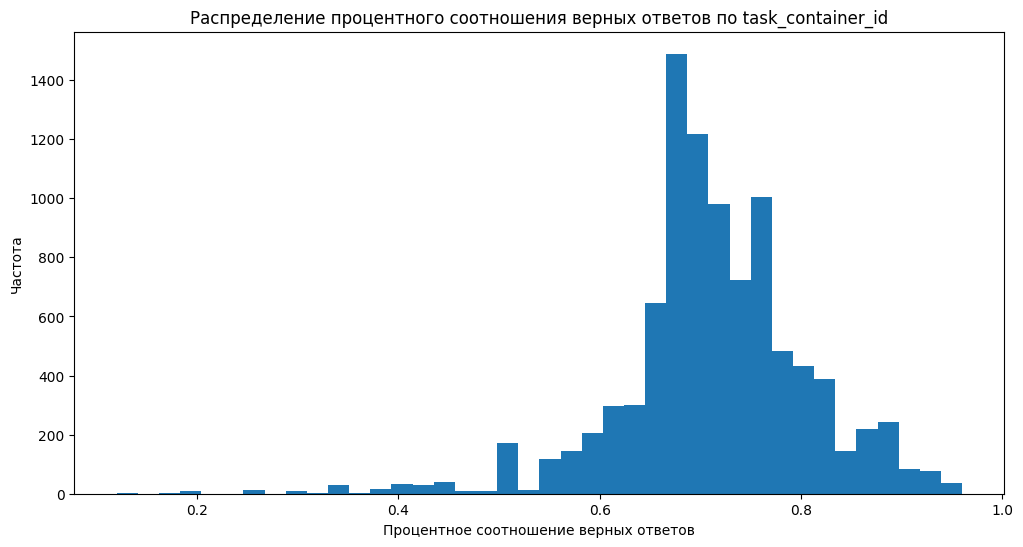

In [64]:
task_id_correct = calculate_percent_correct("task_container_id")

fig, ax = plt.subplots(figsize=(12, 6))
task_id_correct.plot.hist(bins=40, ax=ax)
ax.set_title(
    "Распределение процентного соотношения верных ответов по task_container_id"
)
ax.set_xlabel("Процентное соотношение верных ответов")
ax.set_ylabel("Частота")
plt.show()

Видим, что распределение близко к нормальному.

# prior_question_had_explanation

prior_question_had_explanation
False     286903
True     2693090
Name: (answered_correctly, count), dtype: int64


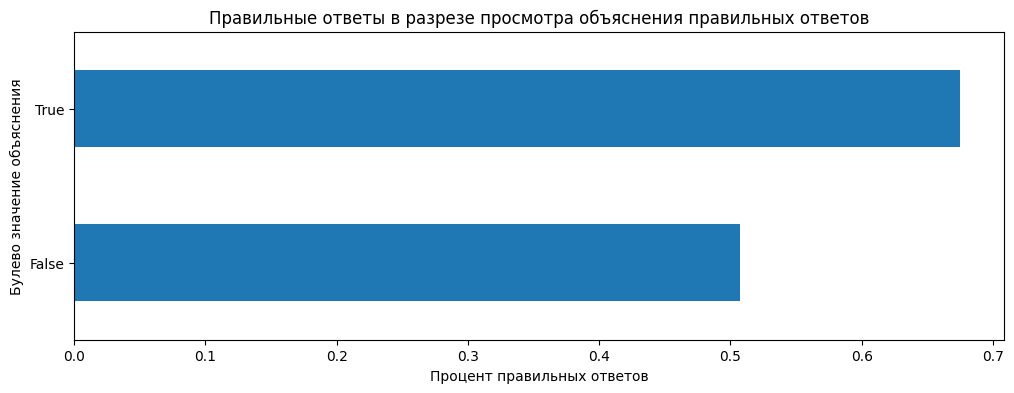

In [65]:
pq = data.groupby(["prior_question_had_explanation"], dropna=False).agg(
    {"answered_correctly": ["mean", "count"]}
)

print(pq.iloc[:, 1])
pq = pq.iloc[:, 0]

fig = plt.figure(figsize=(12, 4))
pq.plot.barh()

plt.title("Правильные ответы в разрезе просмотра объяснения правильных ответов")
plt.xlabel("Процент правильных ответов")
plt.ylabel("Булево значение объяснения")
plt.xticks(rotation=0)
plt.show()

При предварительном объяснении процент правильных ответов увеличивается


# answered_correctly



In [66]:
# Составим матрицу статистик
pq_elapse = data.groupby(["answered_correctly"]).agg(
    {"answered_correctly": ["count"], "prior_question_elapsed_time": ["mean"]}
)
display(pq_elapse)

,answered_correctly,prior_question_elapsed_time
,count,mean
answered_correctly,,
0,1016951,0.426881
1,1963042,0.420721


# user_answer и correct_answer
Возможна утечка на таргет.

In [67]:
# Отметим наличие правильного ответа
us_answ = data[["user_answer", "correct_answer", "answered_correctly"]]
us_answ[us_answ["correct_answer"] == -1]

,user_answer,correct_answer,answered_correctly
2964282,3,-1.0,1
2964283,2,-1.0,0
2964286,0,-1.0,0
2964287,3,-1.0,0
2964288,3,-1.0,1
...,...,...,...
3061502,0,-1.0,0
3061506,1,-1.0,1
3061508,1,-1.0,1
3061509,0,-1.0,1


Выявленны возможные ошибки в данных, есть некоторые данные корректного ответа со значением -1, удаляем их из датасета.

In [68]:
# Фильтруем и смотрим на размер
data = data[data["correct_answer"] != -1]
data.shape

(2941381, 11)

In [69]:
# обратим внимание на возможную утечку
us_answ = data[["user_answer", "correct_answer", "answered_correctly"]]
us_answ["test"] = us_answ["user_answer"] == us_answ["correct_answer"]
us_answ["test"] = us_answ["test"].replace({True: 1, False: 0})

display(us_answ[us_answ["test"] != us_answ["answered_correctly"]])

,user_answer,correct_answer,answered_correctly,test


Утечка подтвердилась, удаляем их.

In [70]:
data = data.drop(columns=["user_answer", "correct_answer"], axis=1)

# tag и tags_group

In [71]:
# Посмотрим на наличие констант
data[["tag", "tags_group"]].value_counts()

tag  tags_group
151  19            335739
     18            195166
     22            166175
     24            147895
     17            140047
     13            135389
     28            132828
     16            128833
     27            127488
     6             118015
     9             115455
     4             111286
     10             88789
     21             86291
     2              82141
     8              79542
     23             75796
     0              64817
     5              61163
     20             59414
     3              58401
     11             57601
     15             57223
     7              50735
     25             43380
     14             38576
     12             37361
     26             31218
     1              21916
     29             15675
Name: count, dtype: int64

tag - константа, удаляем

In [72]:
data = data.drop(columns=["tag"], axis=1)

# Выявим наличие выбросов в датасете

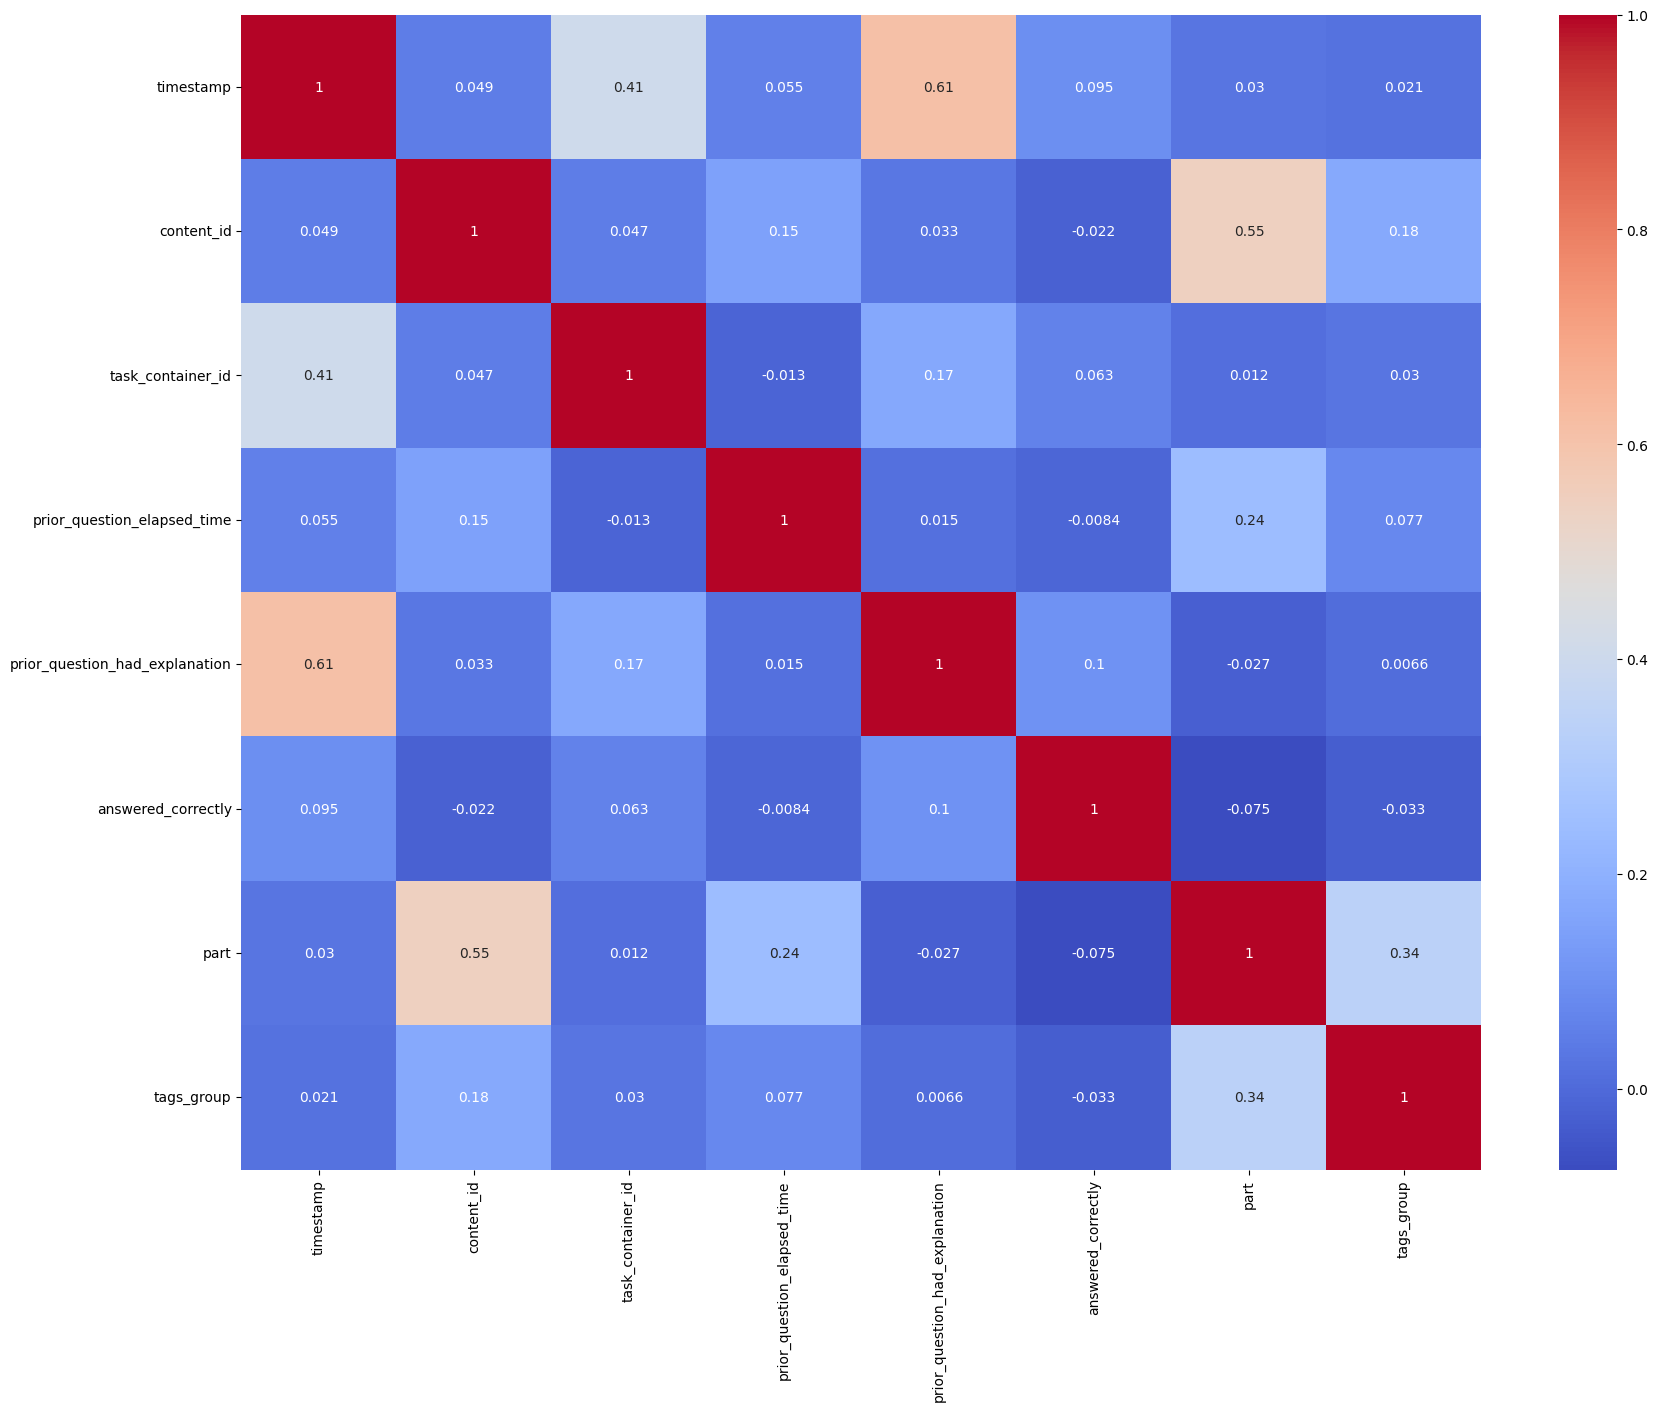

In [73]:
correlation_matrix = data.corr()
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes)
plt.show()

# Вывод

Есть подозрение на мультиколлинеарность, стоит рассмотреть ипользование PCA на timestamp и prior_question_had explanation, content_id и part.

Видно, что корреляция на таргет без утечек со стороны правильного ответа + ответа данного пользователем пострадала. Стоит отметить, что использование в предсказательной модели данных, которые содержат правильный ответ предсказания, не корректным.